# Notebook

## Required Modules
Let us import the modules required to execute B-FADE. The next cell is not necessery if you installed the module via package managers. So you just would skip the cell an jump over.

In [23]:
from sys import path as syspath
from os import path as ospath
syspath.append(ospath.join(ospath.expanduser("~"),
                           '/home/ale/Desktop/b-fade/src'))

In [24]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

import scipy.stats
from sklearn.metrics import log_loss
import pandas as pd

from bfade.elhaddad import ElHaddadCurve, ElHaddadBayes, ElHaddadDataset
from bfade.dataset import SyntheticDataset
from bfade.viewers import BayesViewer, LaplacePosteriorViewer, PreProViewer
from bfade.statistics import MonteCarlo
from bfade.util import parse_arguments, get_config_file, config_matplotlib, logger_manager

# add embellishments (labels, etc.) to the plots.
from bfade.elhaddad import ElHaddadTranslator


``np.seterr`` is set to ignore warning coming from the minimsation of the distance of the dataset's points to the target curve. This do not affect the execution. In fact, if a datum shall not find its minimum-distance counterpart, the latter is not considered. Eventually, when computing the log-likelihood the mismatch between the cardinality of the dataset and the minimum-distance vector is noticed and an exception is raised. This exeception is typically thrown when unphysical points belong to the dataset.

Before starting, it is worth configuring setting of Matplotlib as well as the logging level.

In [25]:
logger_manager(level="DEBUG")
config_matplotlib(font_size=12, font_family="sans-serif",
                  use_latex=False)

A brief note on computing the signed distance to the dataset.

## Dataset
Now we generate a noisy dataset, and we simulate an experimental fatigue and fractography campaign. We start by defining and inspecting an ElHaddadCurve.

15:01:20 - bfade.abstract - WARNING - ElHaddadCurve.inspect
15:01:20 - bfade.util - DEBUG - SHOW PIC: EH-8-700_curve


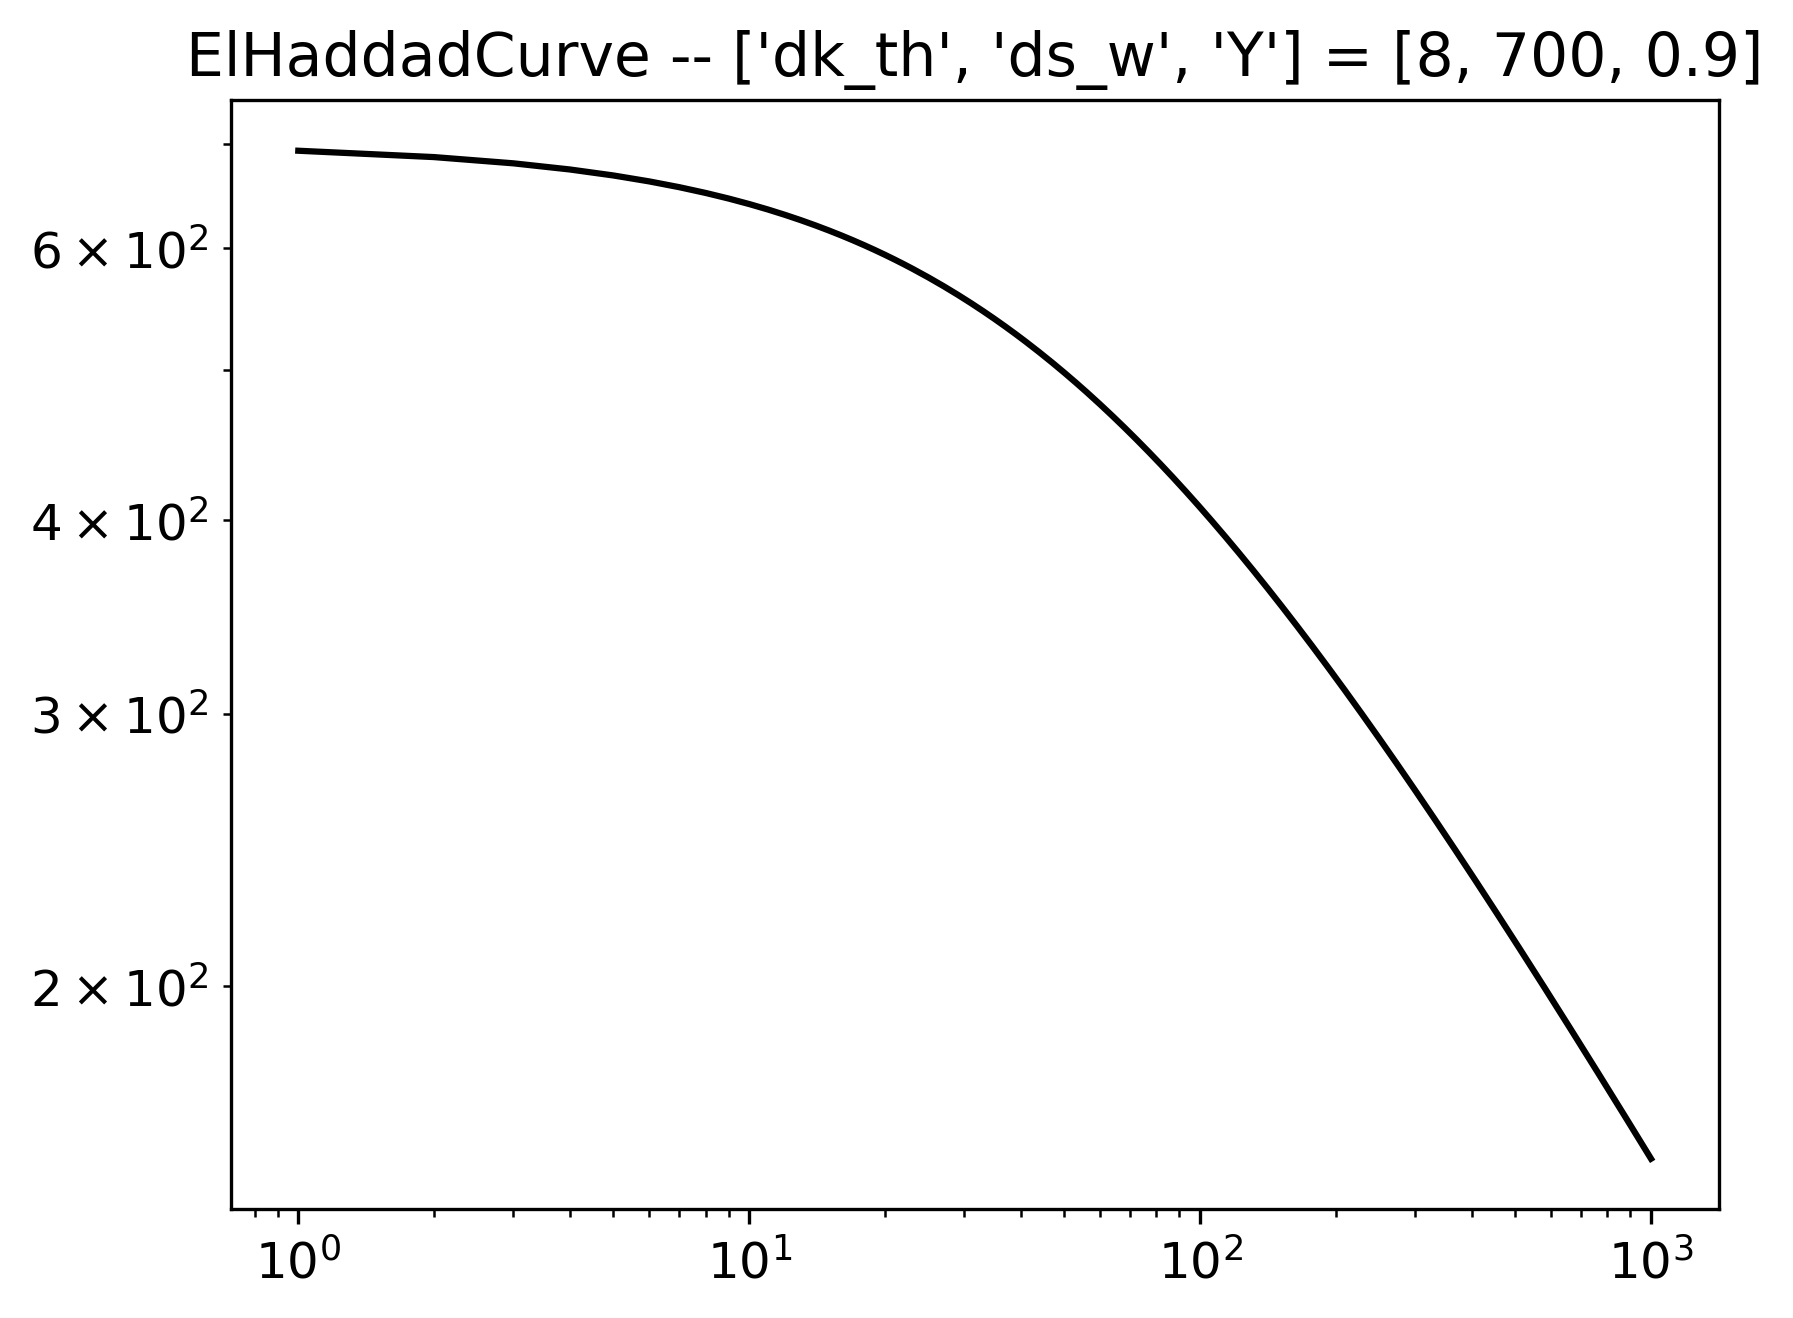

In [26]:
eh = ElHaddadCurve(metrics=np.log10, dk_th=8, ds_w=700, Y=0.9, name="EH-8-700")
eh.inspect(np.linspace(1,1000,1000), scale="log")

15:01:20 - bfade.dataset - DEBUG - ElHaddadDataset.config
15:01:20 - bfade.elhaddad - DEBUG - ElHaddadDataset.pre_process
15:01:20 - bfade.elhaddad - WARNING - Y_ref not user-provided
15:01:20 - bfade.elhaddad - WARNING - Verify uniqueness of Y
15:01:20 - bfade.elhaddad - WARNING - Y is unique = 0.90
15:01:20 - bfade.elhaddad - INFO - Update dataframe
15:01:20 - bfade.elhaddad - WARNING - Convert sqrt_area by 0.90
15:01:20 - bfade.elhaddad - INFO - Compute SIF range
15:01:20 - bfade.elhaddad - DEBUG - Calculate min max of delta_k for colour bars
15:01:20 - bfade.dataset - DEBUG - ElHaddadDataset.inspect
15:01:20 - bfade.util - DEBUG - SHOW PIC: Untitled_data


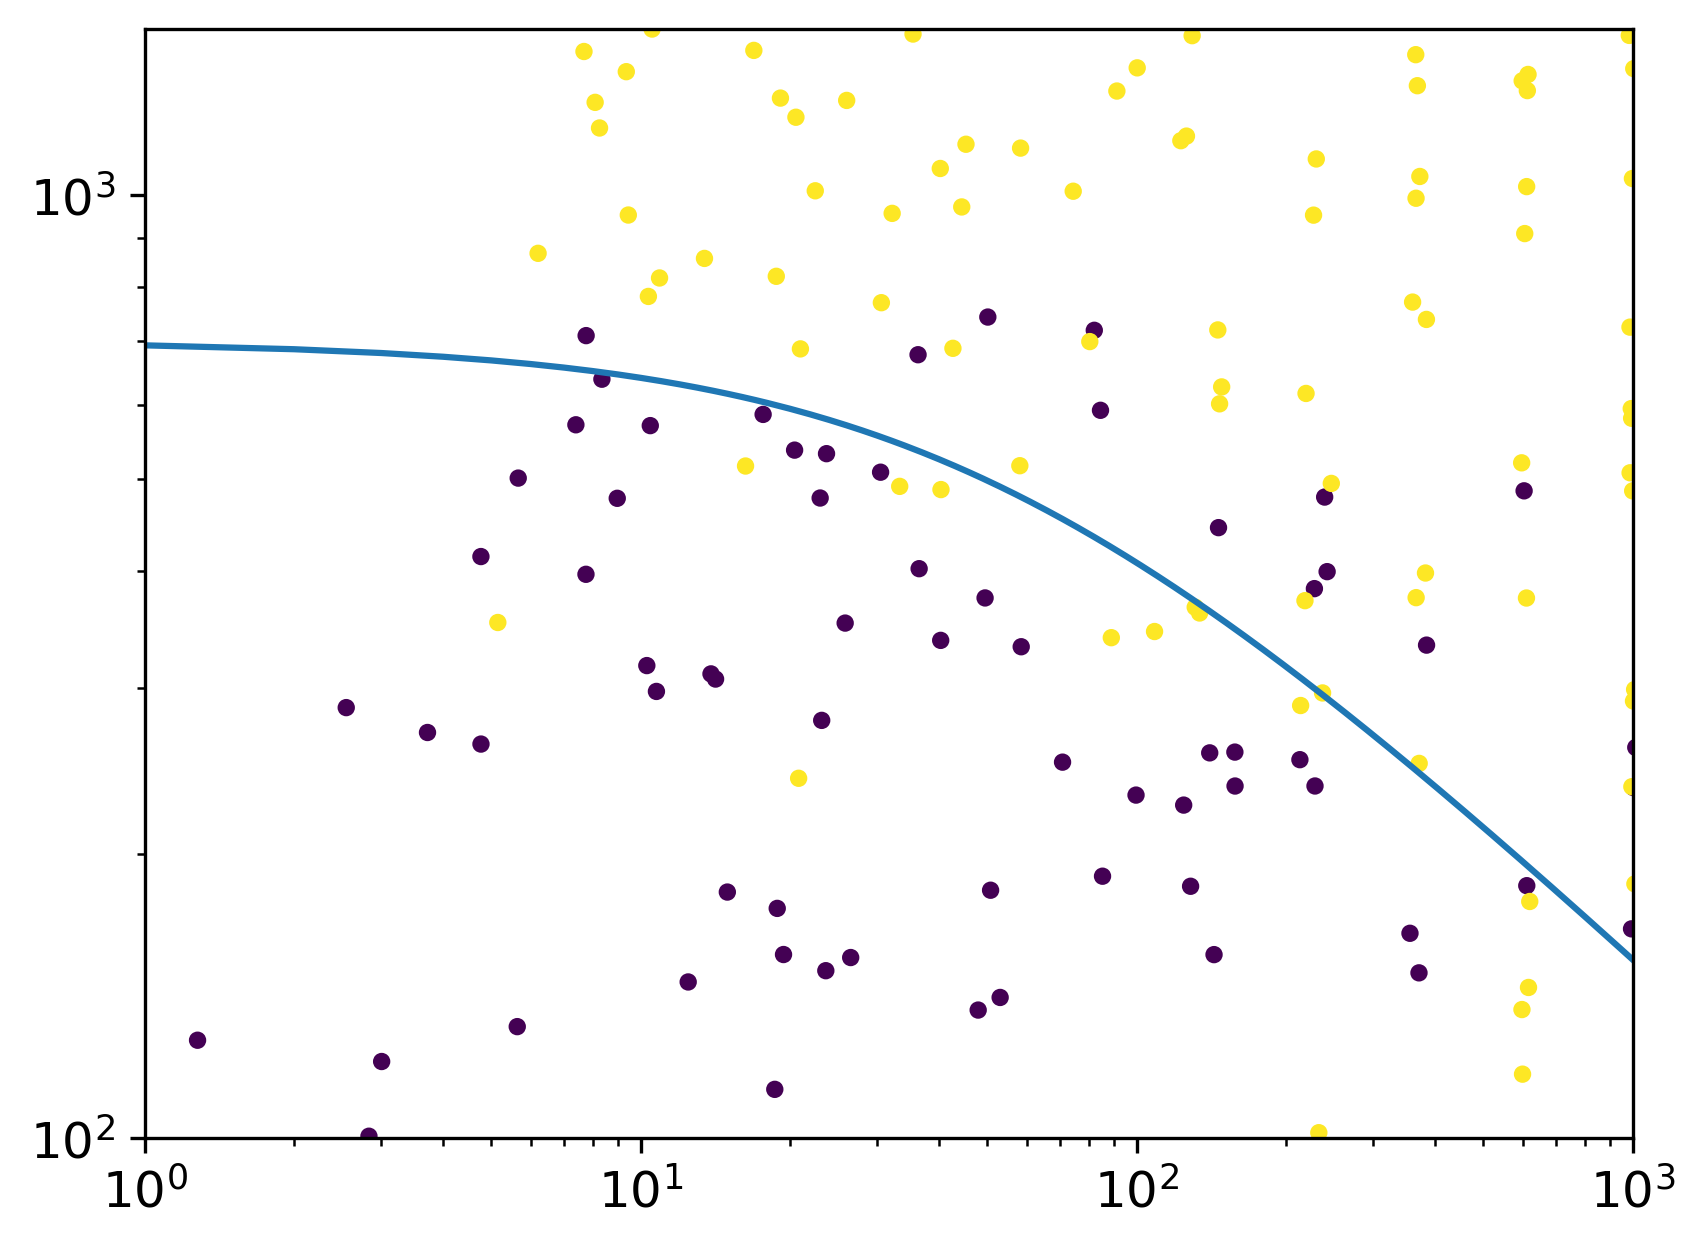

In [27]:
sd = ElHaddadDataset(reader=pd.read_csv, path="./EH-7-800_Noisy.csv")
sd.pre_process()
sd.inspect([1,1000], [100,1500], scale="log", curve=eh, x=np.linspace(1, 1000,1000))

## Bayesian Inference
Let us initilise the Bayesian Infrastructure. In this case the likelihood is normalised, as we shall prescribe priors to facilitate the identification. Particularly, as we known the ground truth parameters we prescribe a Gaussian Prior centered there:

- $\Delta K_{th,lc} \sim \mathcal{N}(8, 0.5)$

- $\Delta\sigma_{w} \sim \mathcal{N}(700, 50)$

Note that the priors take the mean and **standard deviation** as input parameters.

However, we must not anticipate a perfect match with the original parameters, but rather a trade of between those given by the likelihood and prior.

In [28]:
bay = ElHaddadBayes("dk_th", "ds_w", Y=0.9, name="EH-8-700")
bay.load_log_likelihood(log_loss, normalize=True) # True!!!
bay.load_prior("dk_th", scipy.stats.norm, loc=8, scale=2)
bay.load_prior("ds_w", scipy.stats.norm, loc=700, scale=200)

15:01:21 - bfade.statistics - INFO - (Non-scipy). uniform.__init__
15:01:21 - bfade.statistics - INFO - (Non-scipy). uniform.__init__
15:01:21 - bfade.abstract - DEBUG - ElHaddadBayes.__init__ -- ElHaddadBayes({'name': 'EH-8-700', 'pars': ('dk_th', 'ds_w'), 'prior_dk_th': <bfade.statistics.distribution object at 0x7efe726f7190>, 'prior_ds_w': <bfade.statistics.distribution object at 0x7efe72896bb0>})
15:01:21 - bfade.abstract - WARNING - ElHaddadBayes.MAP -- Optimal values unknown. Must run MAP.
15:01:21 - bfade.abstract - INFO - ElHaddadBayes.__init__ -- Deterministic parameter(s) {'Y': 0.9}
15:01:21 - bfade.abstract - INFO - ElHaddadBayes.load_log_likelihood -- <function log_loss at 0x7efe776e64c0>
15:01:21 - bfade.abstract - INFO - ElHaddadBayes.load_prior for dk_th
15:01:21 - bfade.abstract - INFO - ElHaddadBayes.load_prior for ds_w


Display the elements of the Bayes theorem in theri logarithmic form.

15:01:21 - bfade.abstract - DEBUG - BayesViewer.__init__ -- BayesViewer(name = EH-8-700,
 pars = ('dk_th', 'ds_w'),
 p1 = dk_th,
 p2 = ds_w,
 n1 = 25,
 n2 = 25,
 b1 = [3, 10],
 b2 = [600, 1200],
 spacing = lin,
 bounds_dk_th = [3, 10],
 bounds_ds_w = [600, 1200])
15:01:21 - bfade.abstract - DEBUG - BayesViewer.config
15:01:21 - bfade.abstract - DEBUG - BayesViewer.config_contour
15:01:21 - bfade.abstract - DEBUG - BayesViewer.config_contour
15:01:21 - bfade.viewers - DEBUG - BayesViewer.contour. Contour: log_prior
15:01:21 - bfade.util - DEBUG - SHOW PIC: EH-8-700_bay_log_prior


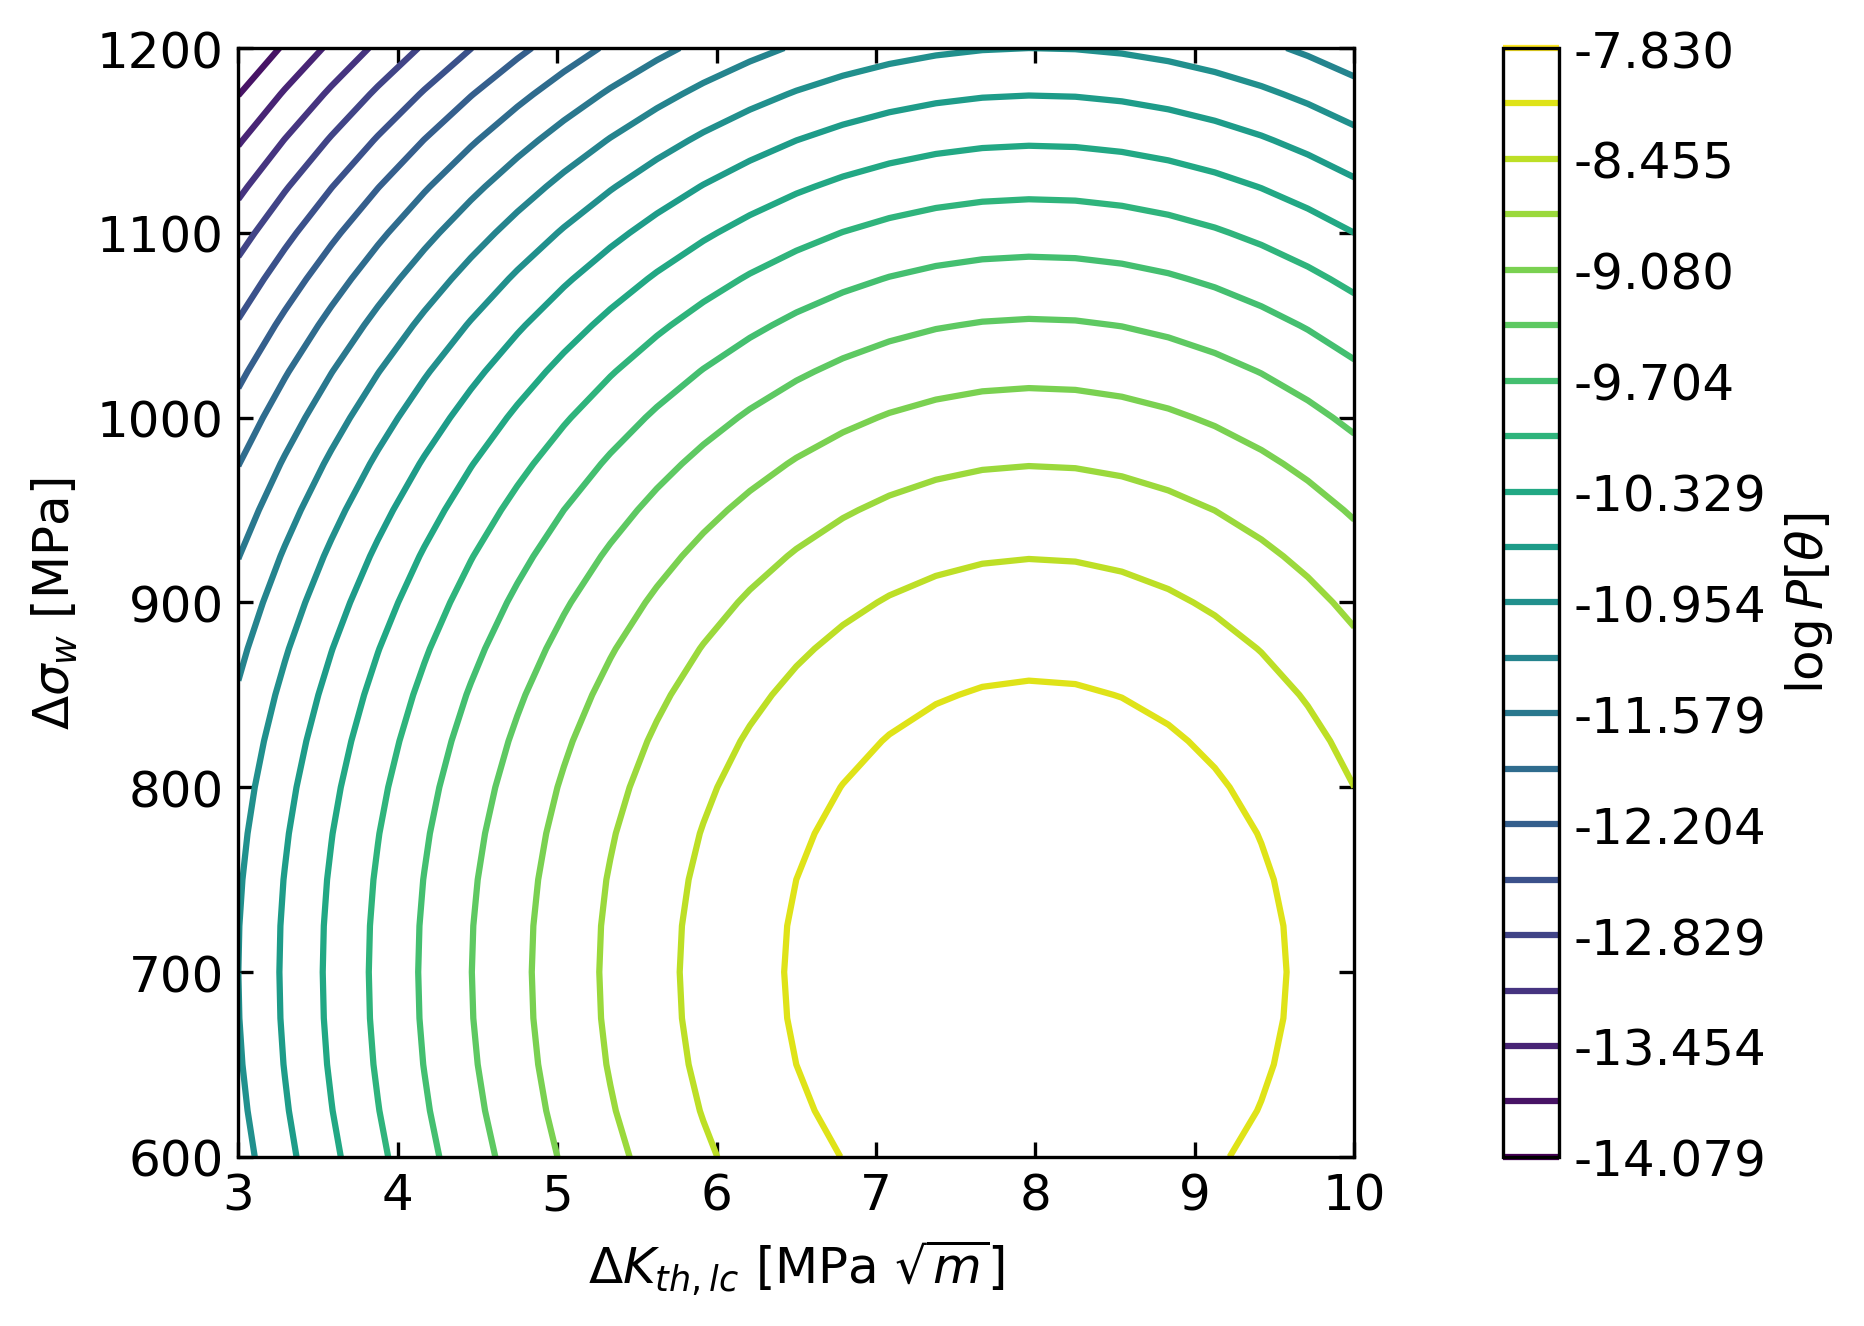

15:01:21 - bfade.viewers - DEBUG - BayesViewer.contour. Contour: log_likelihood
15:01:50 - bfade.util - DEBUG - SHOW PIC: EH-8-700_bay_log_likelihood


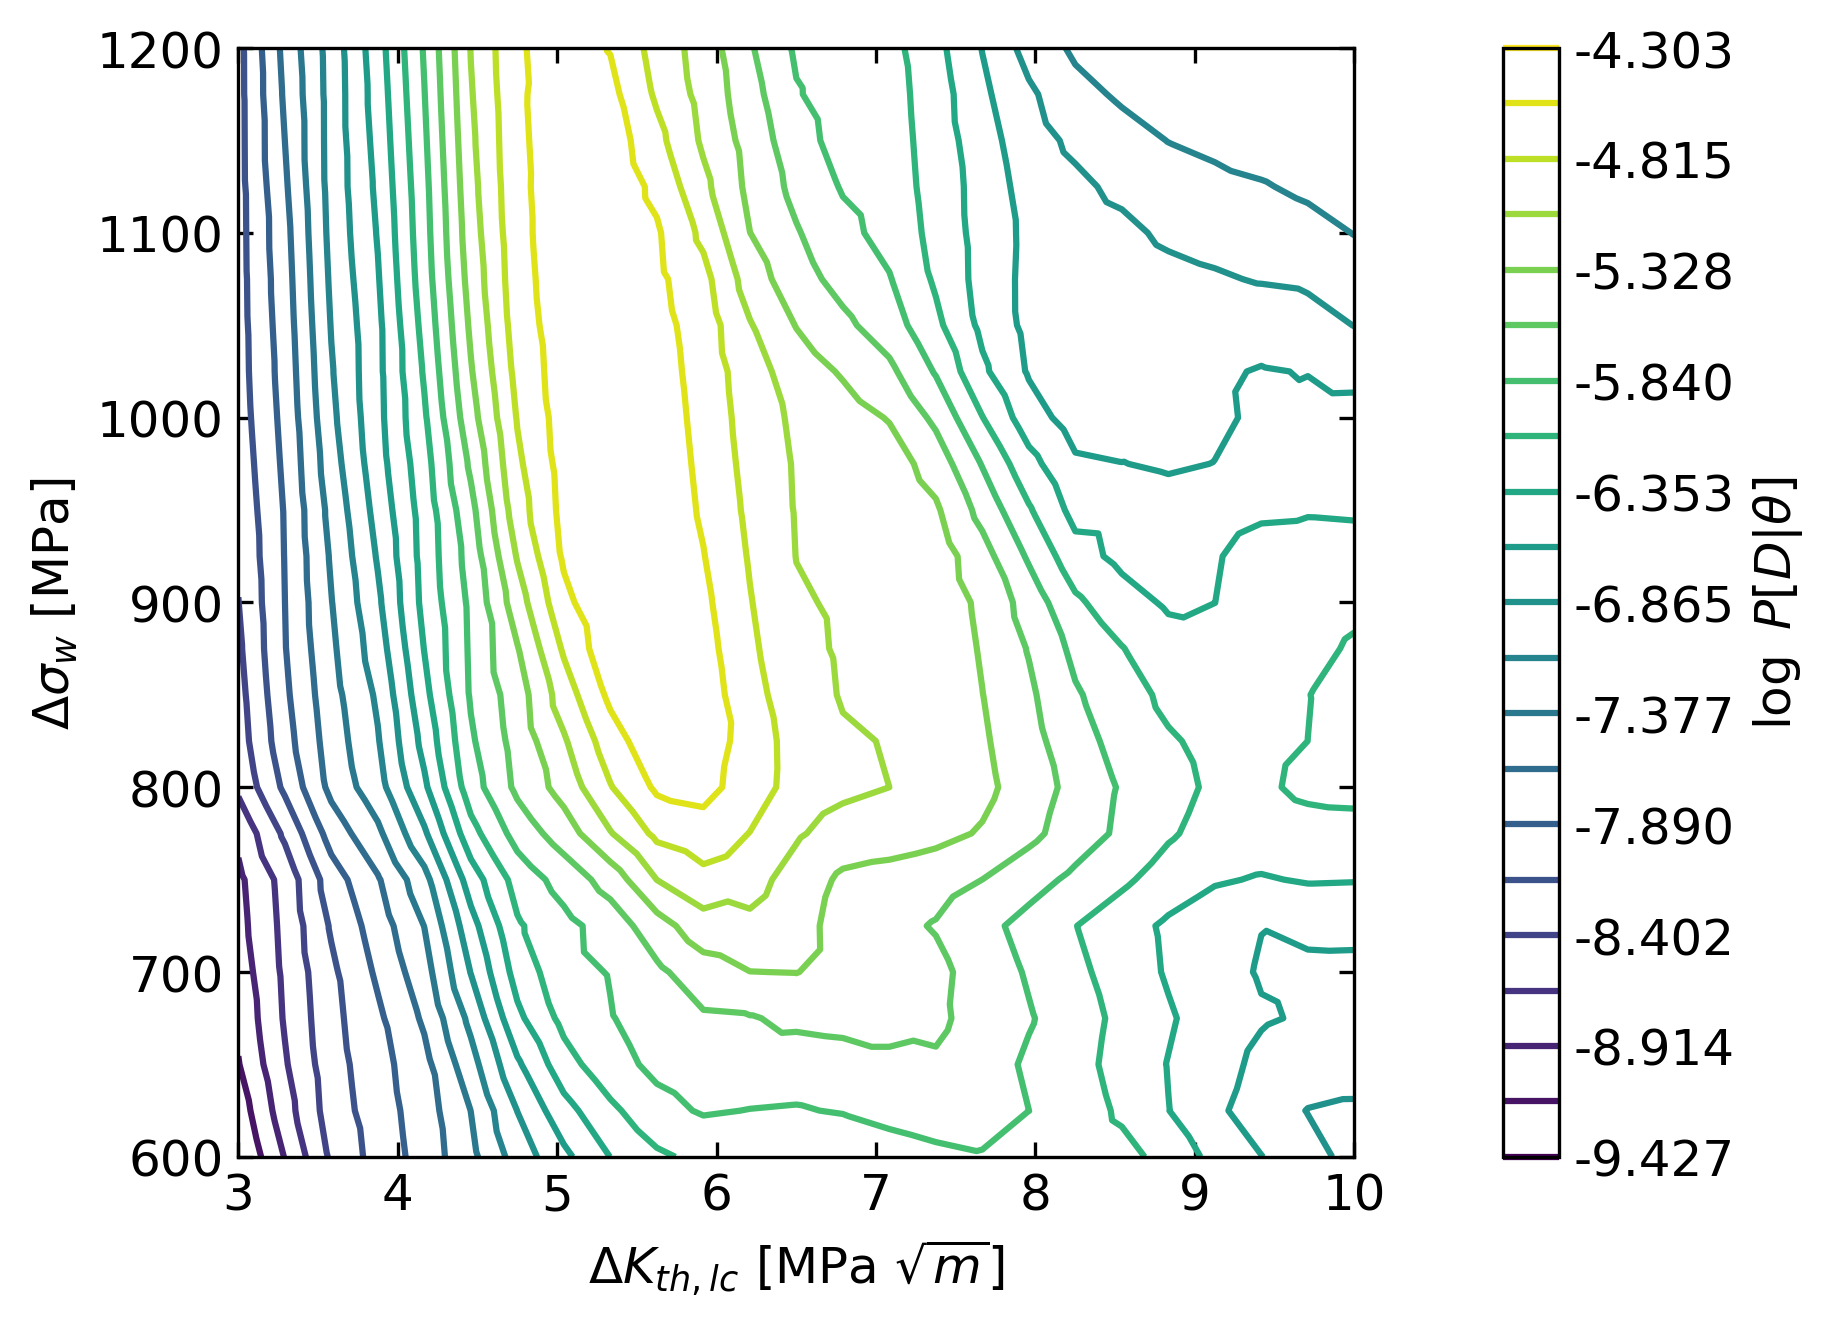

15:01:51 - bfade.viewers - DEBUG - BayesViewer.contour. Contour: log_posterior
15:02:20 - bfade.util - DEBUG - SHOW PIC: EH-8-700_bay_log_posterior


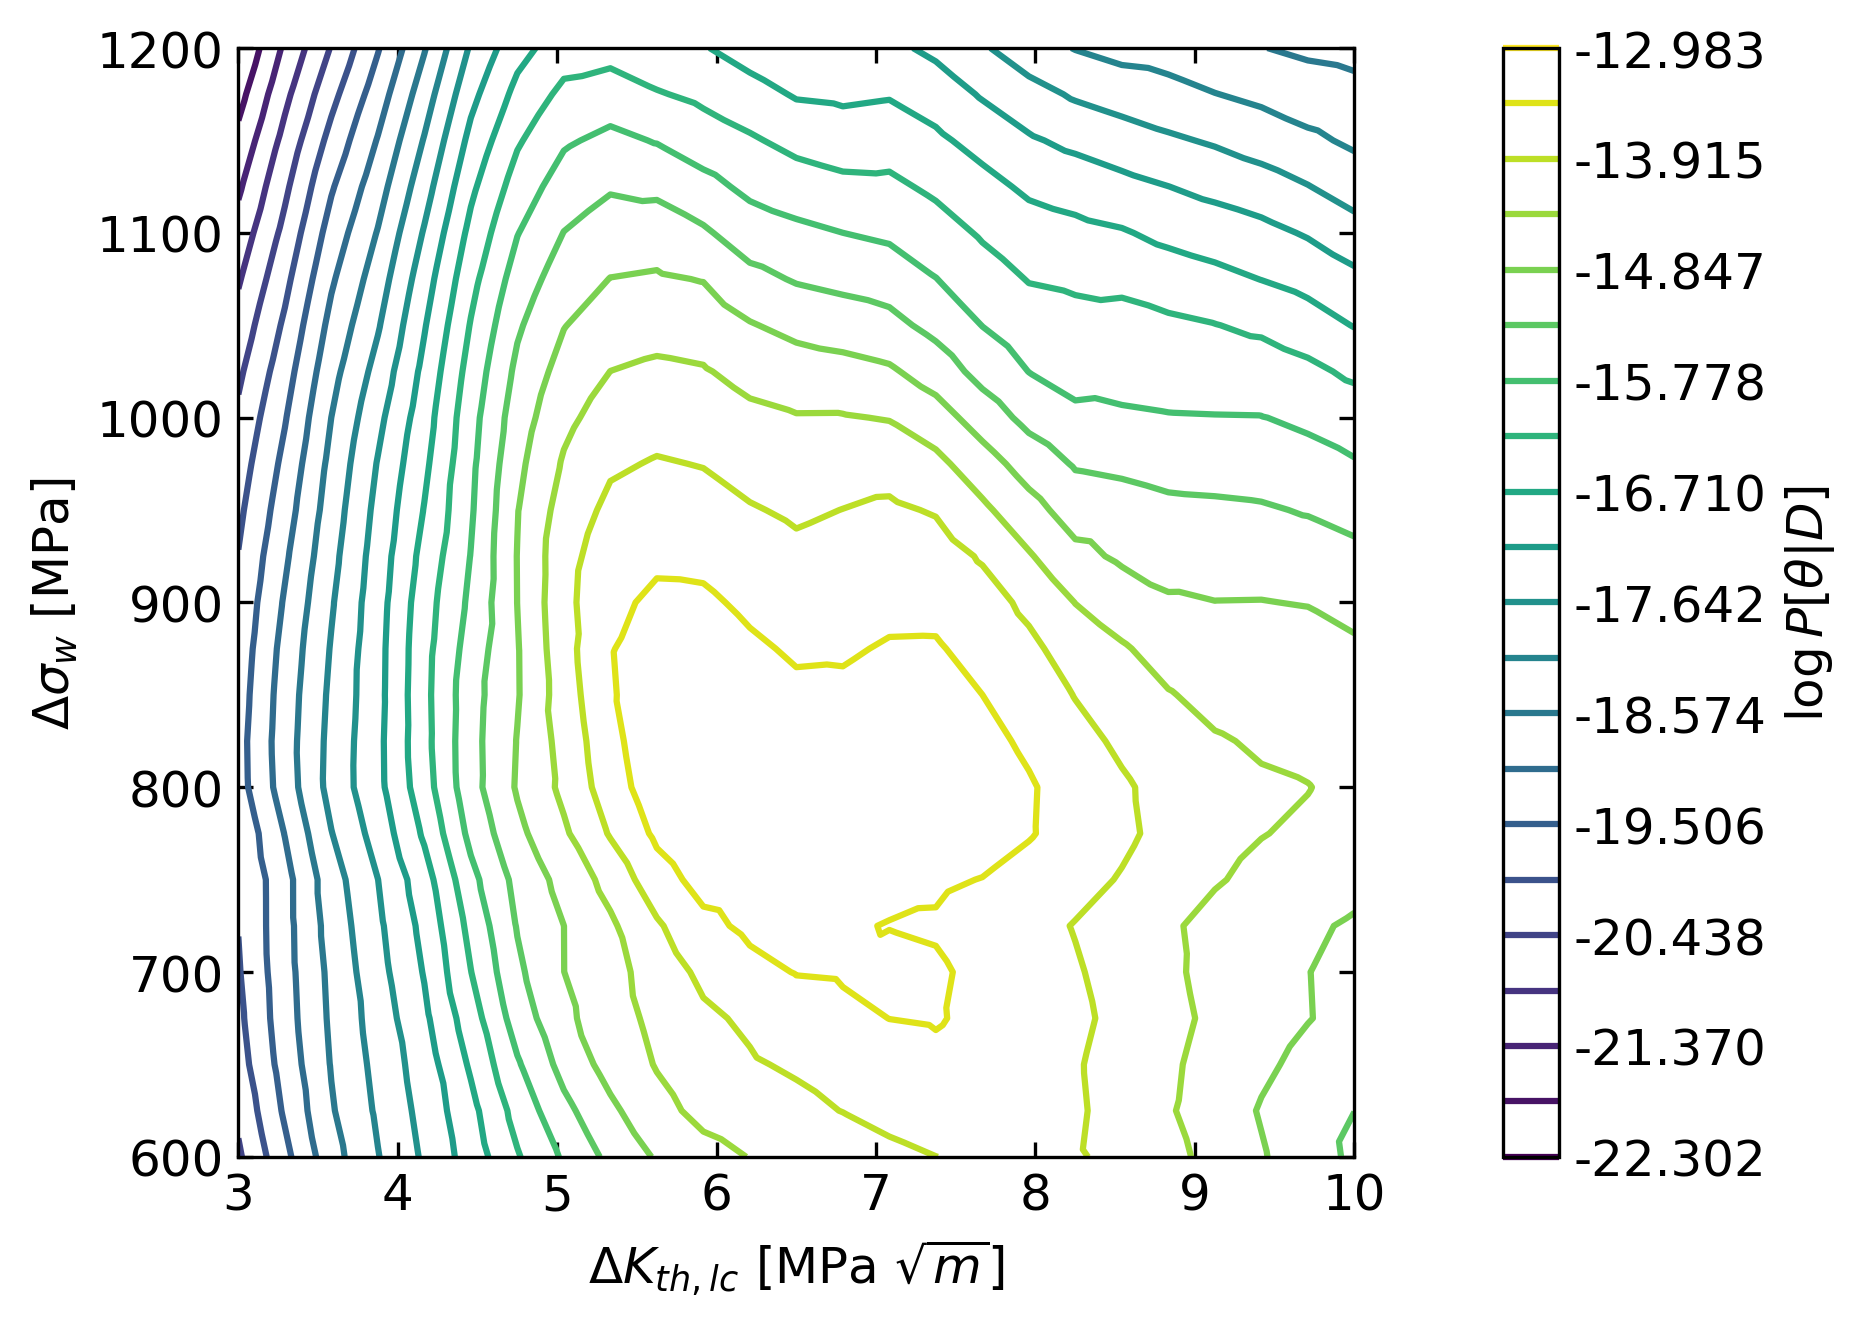

In [29]:
v = BayesViewer("dk_th", [3,10], 25, "ds_w", [600, 1200], 25, name="EH-8-700")
v.config_contour(translator=ElHaddadTranslator)
v.contour("log_prior", bay)
v.contour("log_likelihood", bay, sd)
v.contour("log_posterior", bay, sd)

We run MAP initialising the optimiser nearby the stationary point of the posterior.

In [30]:
bay.MAP(sd, x0=[5,500])

15:02:20 - bfade.abstract - INFO - ElHaddadBayes.MAP -- Default solver Nelder-Mead, {'disp': True, 'maxiter': 10000000000.0}
15:02:20 - bfade.abstract - WARNING - ElHaddadBayes.MAP -- Run MAP.
15:02:21 - bfade.abstract - INFO - Iter: 0 -- Params: [  5.375 537.5  ] -- Min 15.704
15:02:21 - bfade.abstract - INFO - Iter: 1 -- Params: [  5.375 537.5  ] -- Min 15.704
15:02:21 - bfade.abstract - INFO - Iter: 2 -- Params: [  5.75 600.  ] -- Min 14.670
15:02:21 - bfade.abstract - INFO - Iter: 3 -- Params: [  5.75 600.  ] -- Min 14.670
15:02:21 - bfade.abstract - INFO - Iter: 4 -- Params: [  6.875 687.5  ] -- Min 13.446
15:02:21 - bfade.abstract - INFO - Iter: 5 -- Params: [  6.9375 781.25  ] -- Min 13.196
15:02:21 - bfade.abstract - INFO - Iter: 6 -- Params: [  7.484375 801.5625  ] -- Min 13.137
15:02:22 - bfade.abstract - INFO - Iter: 7 -- Params: [  7.484375 801.5625  ] -- Min 13.137
15:02:22 - bfade.abstract - INFO - Iter: 8 -- Params: [  7.484375 801.5625  ] -- Min 13.137
15:02:22 - bfade.

Optimization terminated successfully.
         Current function value: 13.095508
         Iterations: 49
         Function evaluations: 100


15:02:33 - bfade.abstract - DEBUG - ElHaddadBayes.laplace_posterior -- Load distributions.
15:02:33 - bfade.abstract - WARNING - ElHaddadBayes.MAP -- theta_hat [  7.24468876 794.40995672]
15:02:33 - bfade.abstract - WARNING - ElHaddadBayes.MAP -- ihess [[ 3.61097900e-01 -1.21557051e+00]
 [-1.21557051e+00  7.07238234e+02]]


As we can see from the log, ``theta_hat`` is pretty close to the hypothesised values despite the noisy data, owing to the prescribed prior distribution.

## Laplace Posterior
Once MAP is accomplished, it is possible to display the approximated Laplace posterior. To do so the user is required to istantiate a specific viewer.

In [31]:
l = LaplacePosteriorViewer("dk_th", 4, 100, "ds_w", 4, 100, bay)
# override bounds
l.config_contour(xlim=[3,10], ylim=[600,1200], translator=ElHaddadTranslator)

15:02:33 - bfade.viewers - DEBUG - LaplacePosteriorViewer.__init__
15:02:33 - bfade.abstract - DEBUG - LaplacePosteriorViewer.__init__ -- LaplacePosteriorViewer(c1 = 4,
 c2 = 4,
 name = Untitled,
 pars = ('dk_th', 'ds_w'),
 p1 = dk_th,
 p2 = ds_w,
 n1 = 100,
 n2 = 100,
 b1 = [4.84103189 9.64834564],
 b2 = [688.03415237 900.78576107],
 spacing = lin,
 bounds_dk_th = [4.84103189 9.64834564],
 bounds_ds_w = [688.03415237 900.78576107])
15:02:33 - bfade.abstract - DEBUG - LaplacePosteriorViewer.config
15:02:33 - bfade.abstract - DEBUG - LaplacePosteriorViewer.config_contour
15:02:33 - bfade.abstract - DEBUG - LaplacePosteriorViewer.config_contour


15:02:33 - bfade.viewers - DEBUG - LaplacePosteriorViewer.contour -- joint poterior
15:02:33 - bfade.util - DEBUG - SHOW PIC: Untitled_laplace_joint


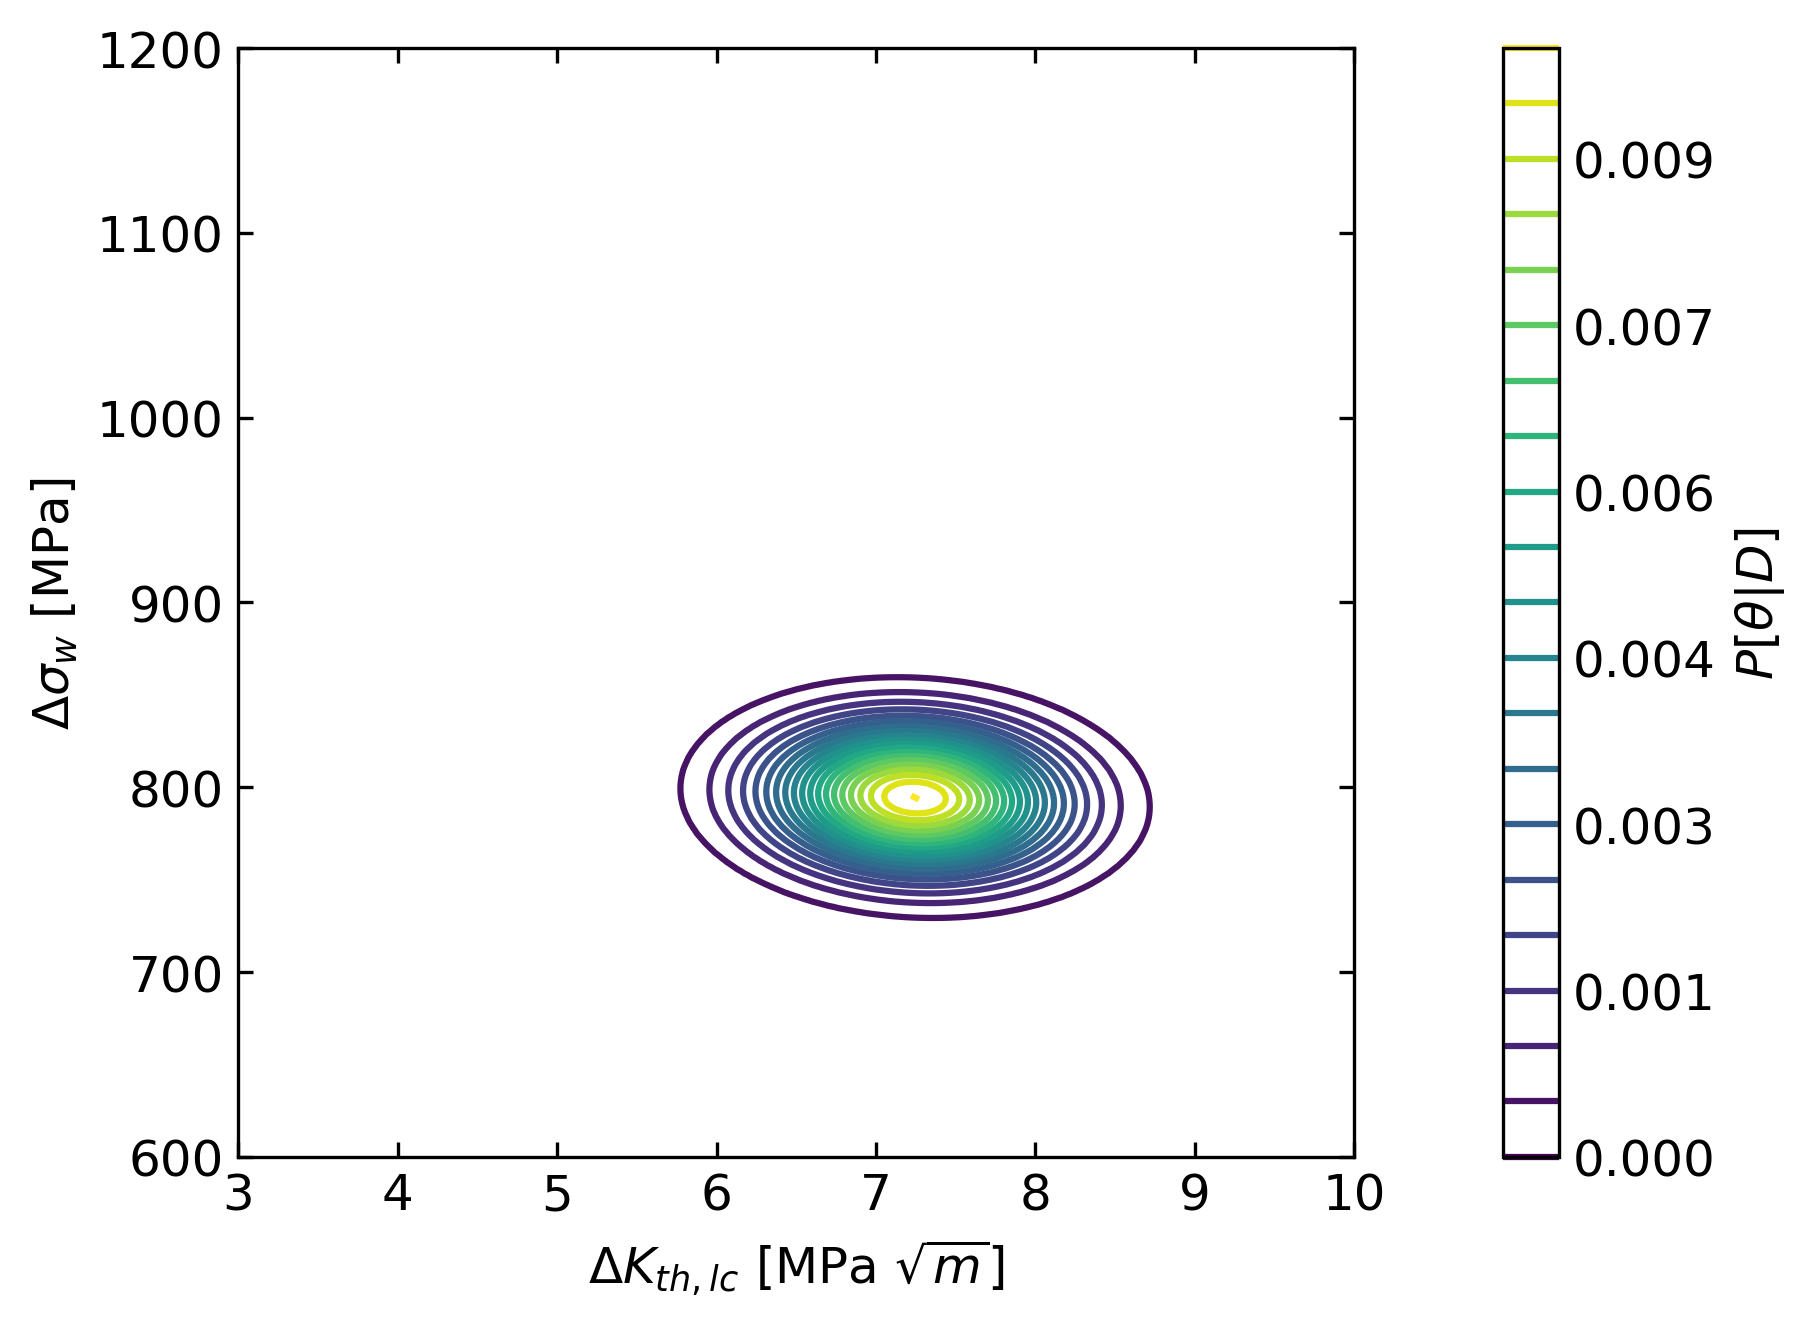

15:02:34 - bfade.viewers - DEBUG - LaplacePosteriorViewer.marginals
15:02:34 - bfade.util - DEBUG - SHOW PIC: Untitled_lap_marginal_dk_th


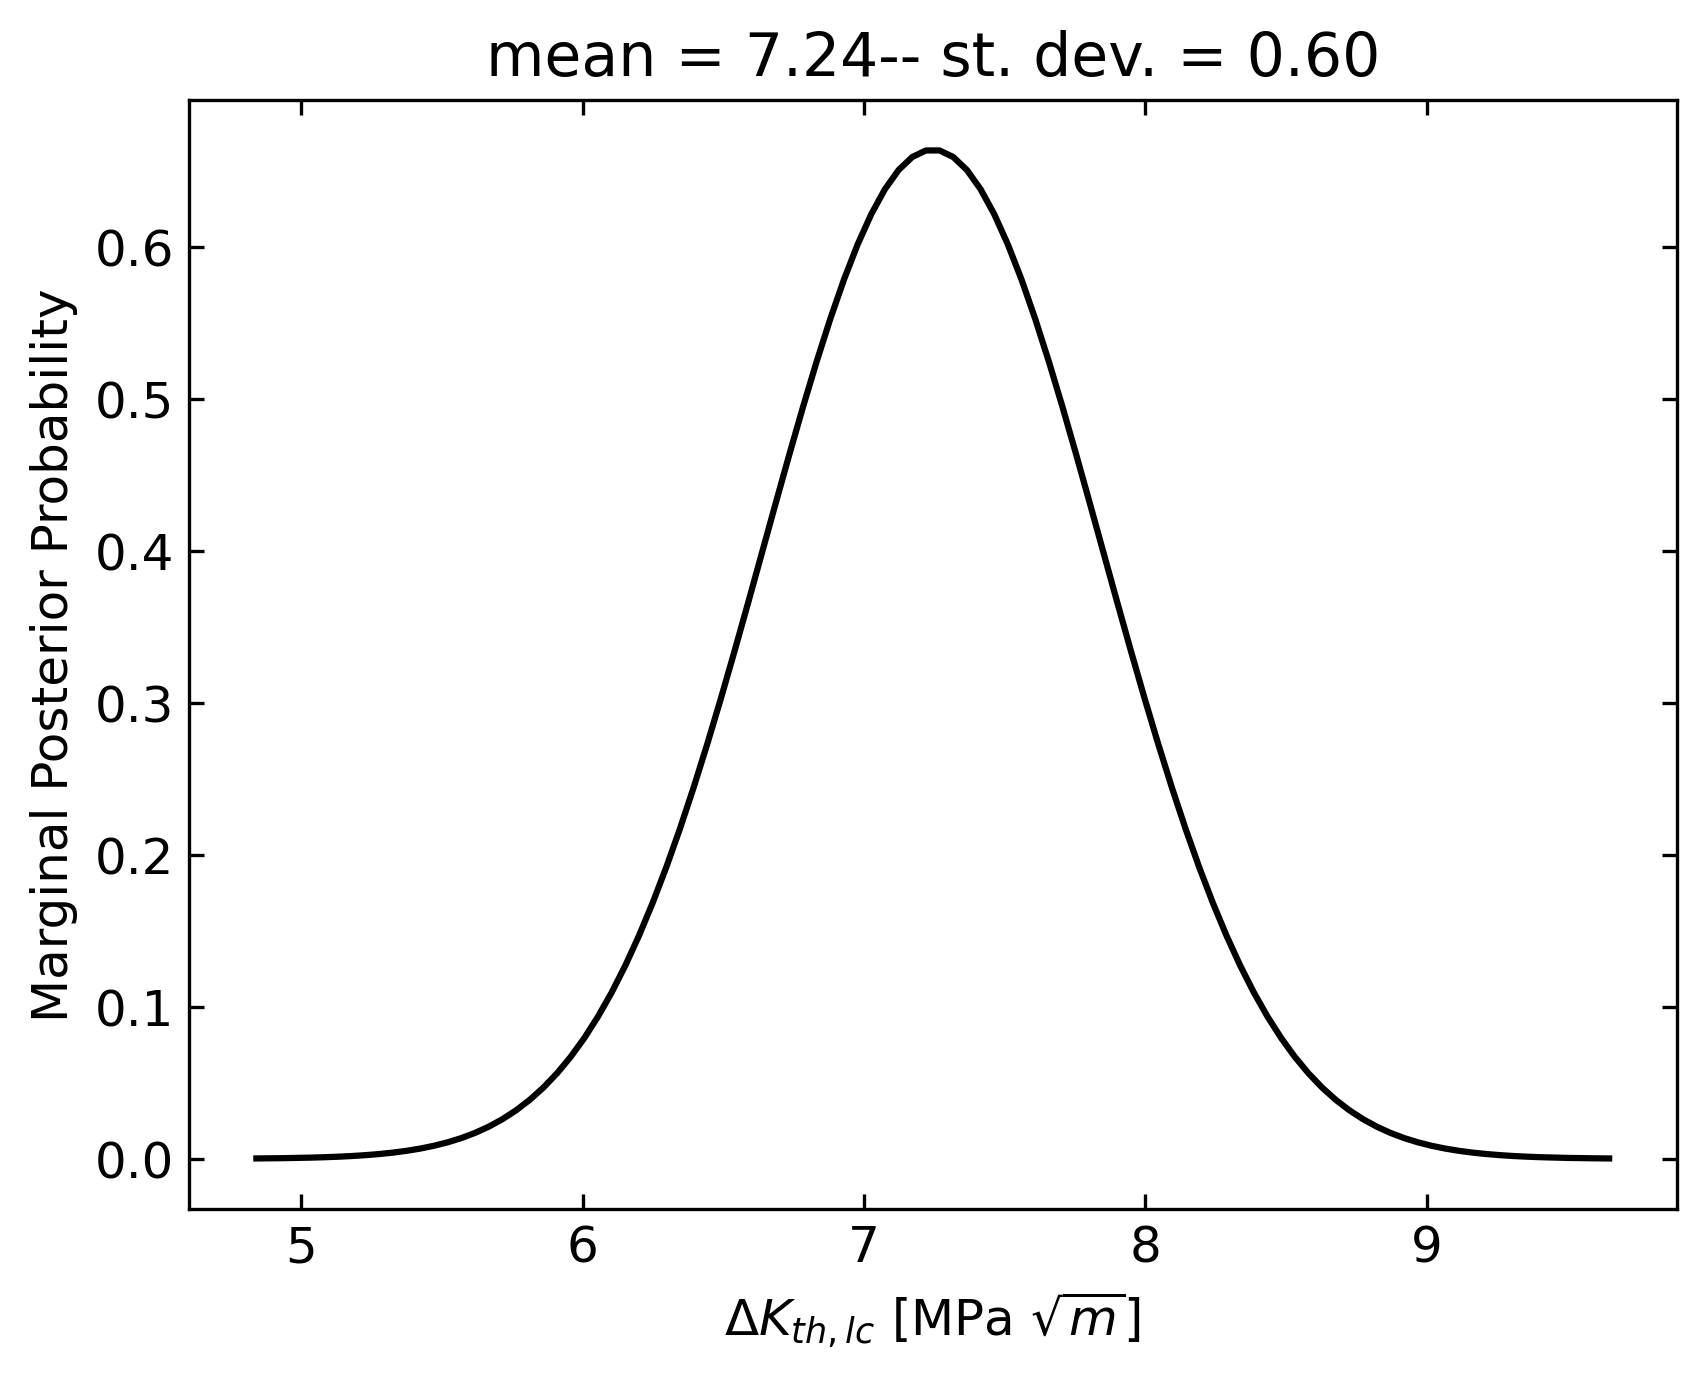

15:02:34 - bfade.viewers - DEBUG - LaplacePosteriorViewer.marginals
15:02:34 - bfade.util - DEBUG - SHOW PIC: Untitled_lap_marginal_ds_w


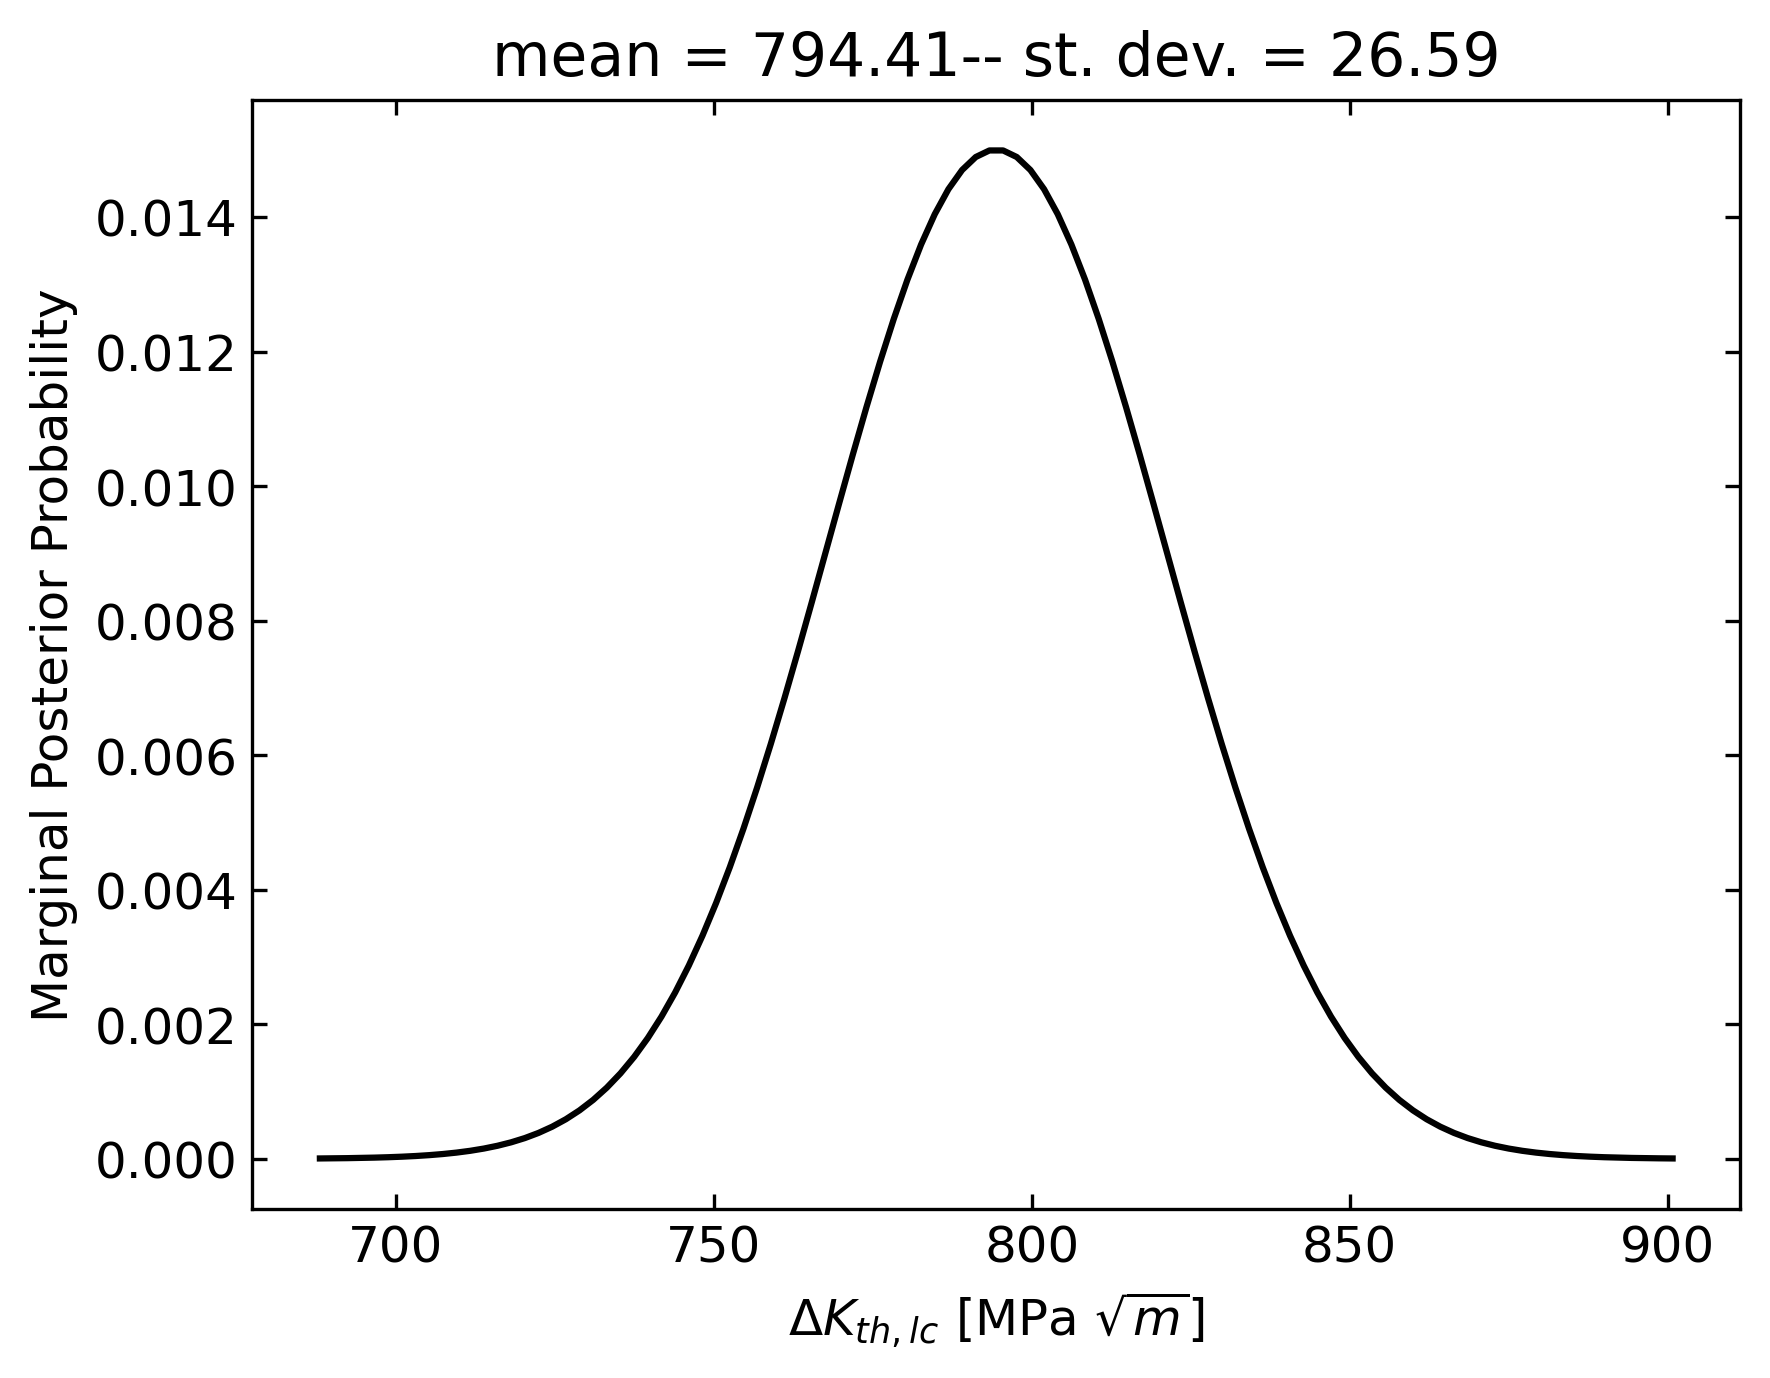

In [32]:
l.contour(bay)
l.marginals("dk_th", bay)
l.marginals("ds_w", bay)

## Inspecting Results
Finally, we display the results of the Bayesian Inference as well as the training data. Since we ran MAP, the predictive posterior is available too. Furthermore, we istantiate a MonteCarlo object to compute the prediction intervals for the estimated El Haddad curve. In this regard, we do not run expliclty a Monte Carlo simulation, but we rely on the interface of PreProViewer to trigger the computations. Similarly, the predictive posterior is not directly computed, though the computation are triggered via the interface of the viewer. As for the predictive posterior, an evaluation grid is required.

15:02:34 - bfade.viewers - DEBUG - PreProViewer.__init__ -- PreProViewer(x_edges = [1, 1000],
 y_edges = [100, 1500],
 x_scale = log,
 y_scale = log,
 n = 1000,
 name = EH-7-800,
 det_pars = {})
15:02:34 - bfade.viewers - DEBUG - PreProViewer.config
15:02:34 - bfade.viewers - DEBUG - PreProViewer.config_canvas
15:02:34 - bfade.viewers - DEBUG - PreProViewer.config_canvas
15:02:34 - bfade.statistics - DEBUG - MonteCarlo.__init__
15:02:34 - bfade.dataset - DEBUG - SyntheticDataset.config
15:02:34 - bfade.dataset - DEBUG - SyntheticDataset.make_grid
15:02:34 - bfade.viewers - INFO - Inspect training data
15:02:34 - bfade.viewers - DEBUG - PreProViewer.add_colourbar
15:02:34 - bfade.viewers - DEBUG - State: EH-7-800_train
15:02:34 - bfade.viewers - INFO - Inspect given curves
15:02:34 - bfade.viewers - DEBUG - State: EH-7-800_train_EH-8-700
15:02:34 - bfade.viewers - DEBUG - State: EH-7-800_train_EH-8-700_EH-7-800-Estimated
15:02:34 - bfade.viewers - INFO - Inspect prediction interval
15:0

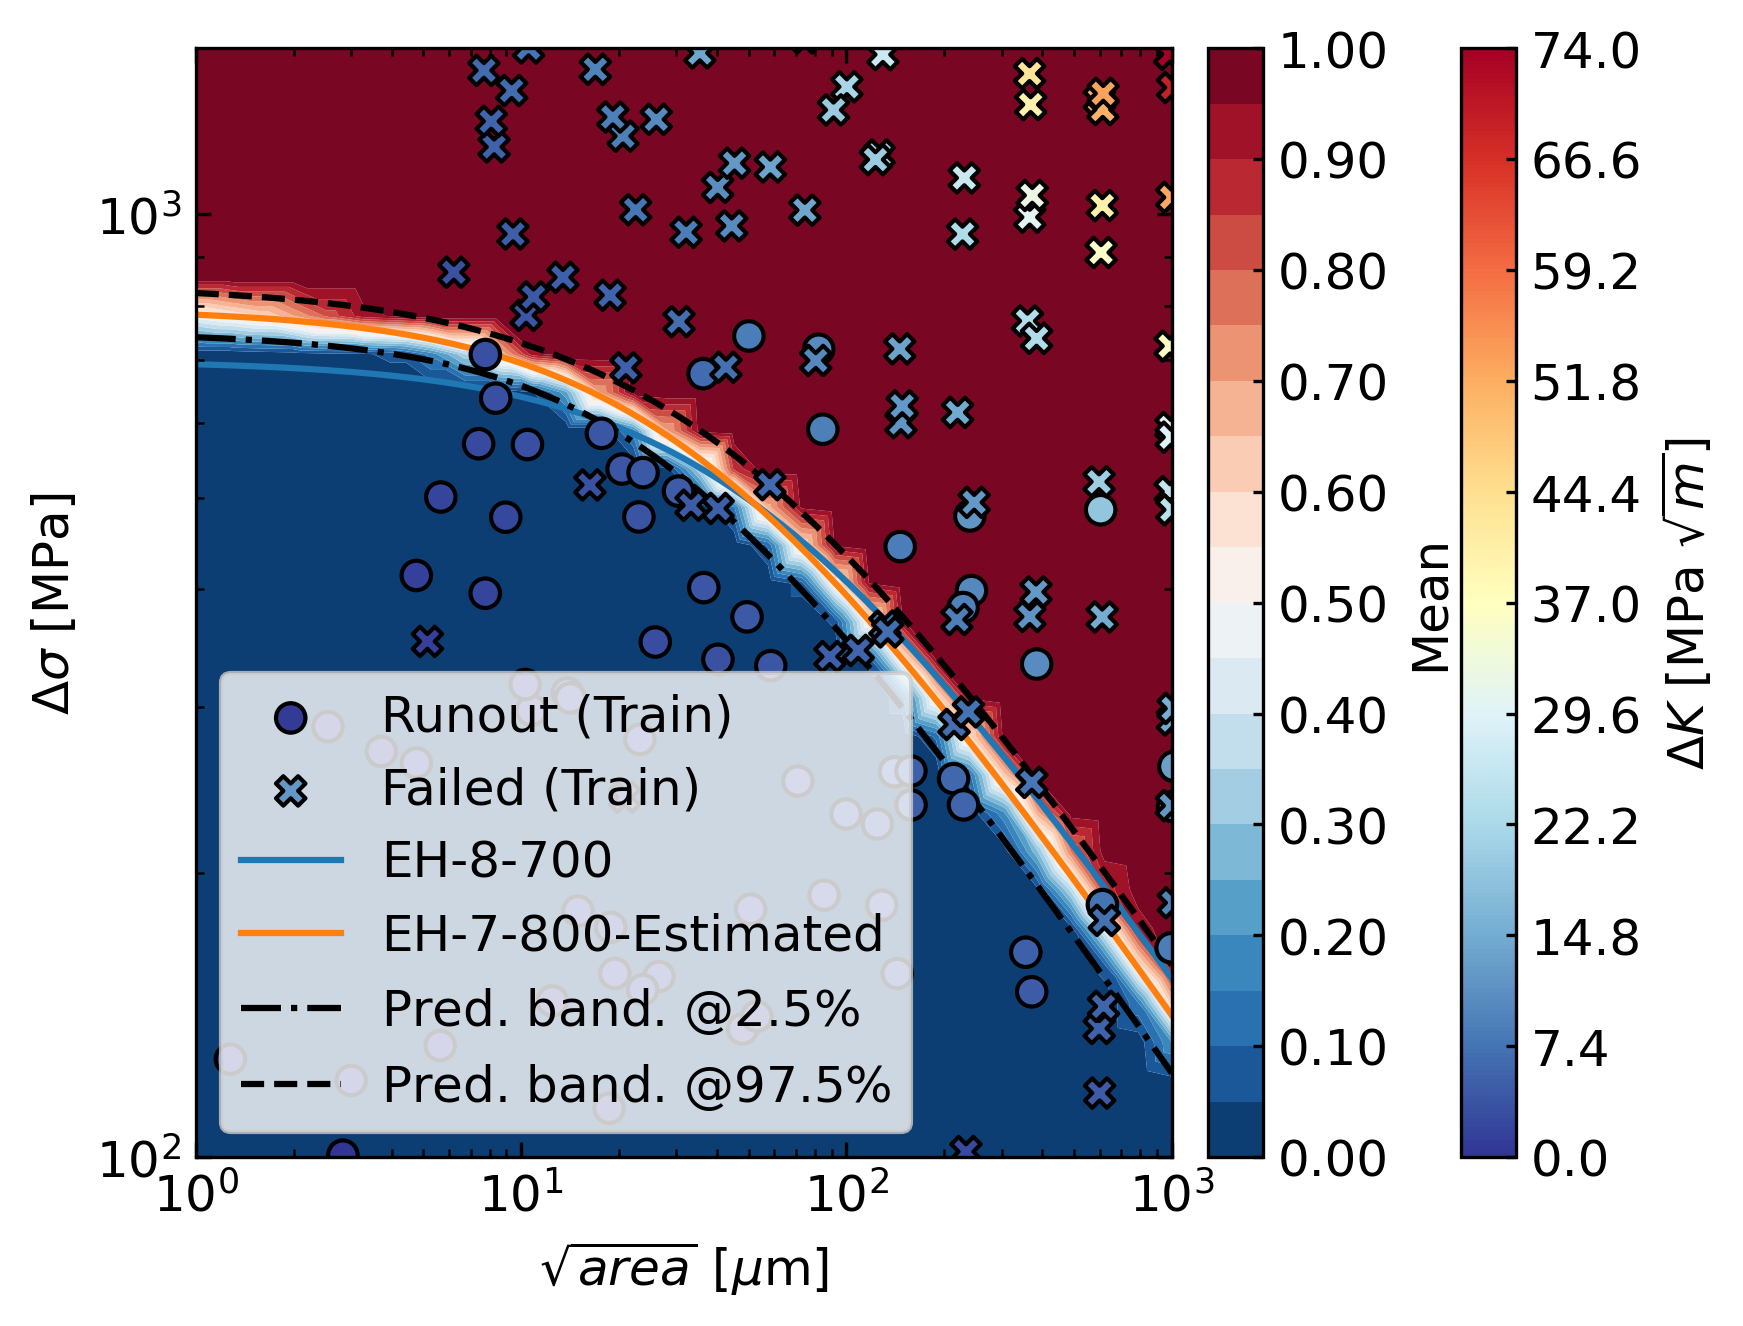

15:02:46 - bfade.viewers - INFO - Inspect training data
15:02:46 - bfade.viewers - DEBUG - PreProViewer.add_colourbar
15:02:46 - bfade.viewers - DEBUG - State: EH-7-800_train
15:02:46 - bfade.viewers - INFO - Inspect given curves
15:02:46 - bfade.viewers - DEBUG - State: EH-7-800_train_EH-8-700
15:02:46 - bfade.viewers - DEBUG - State: EH-7-800_train_EH-8-700_EH-7-800-Estimated
15:02:46 - bfade.viewers - INFO - Inspect prediction interval
15:02:46 - bfade.statistics - DEBUG - MonteCarlo.sample -- Joint, samples = 10000
15:02:46 - bfade.statistics - INFO - MonteCarlo.prediction_interval -- Confidence = 0.95%
15:02:46 - bfade.viewers - DEBUG - State: EH-7-800_train_EH-8-700_EH-7-800-Estimated_pi
15:02:46 - bfade.viewers - INFO - Inspect predictive posterior
15:02:46 - bfade.abstract - DEBUG - ElHaddadBayes.predictive_posterior
15:02:57 - bfade.abstract - DEBUG - ElHaddadBayes.predictive_posterior -- Return prediction stack
15:02:57 - bfade.viewers - DEBUG - State: EH-7-800_train_EH-8-700

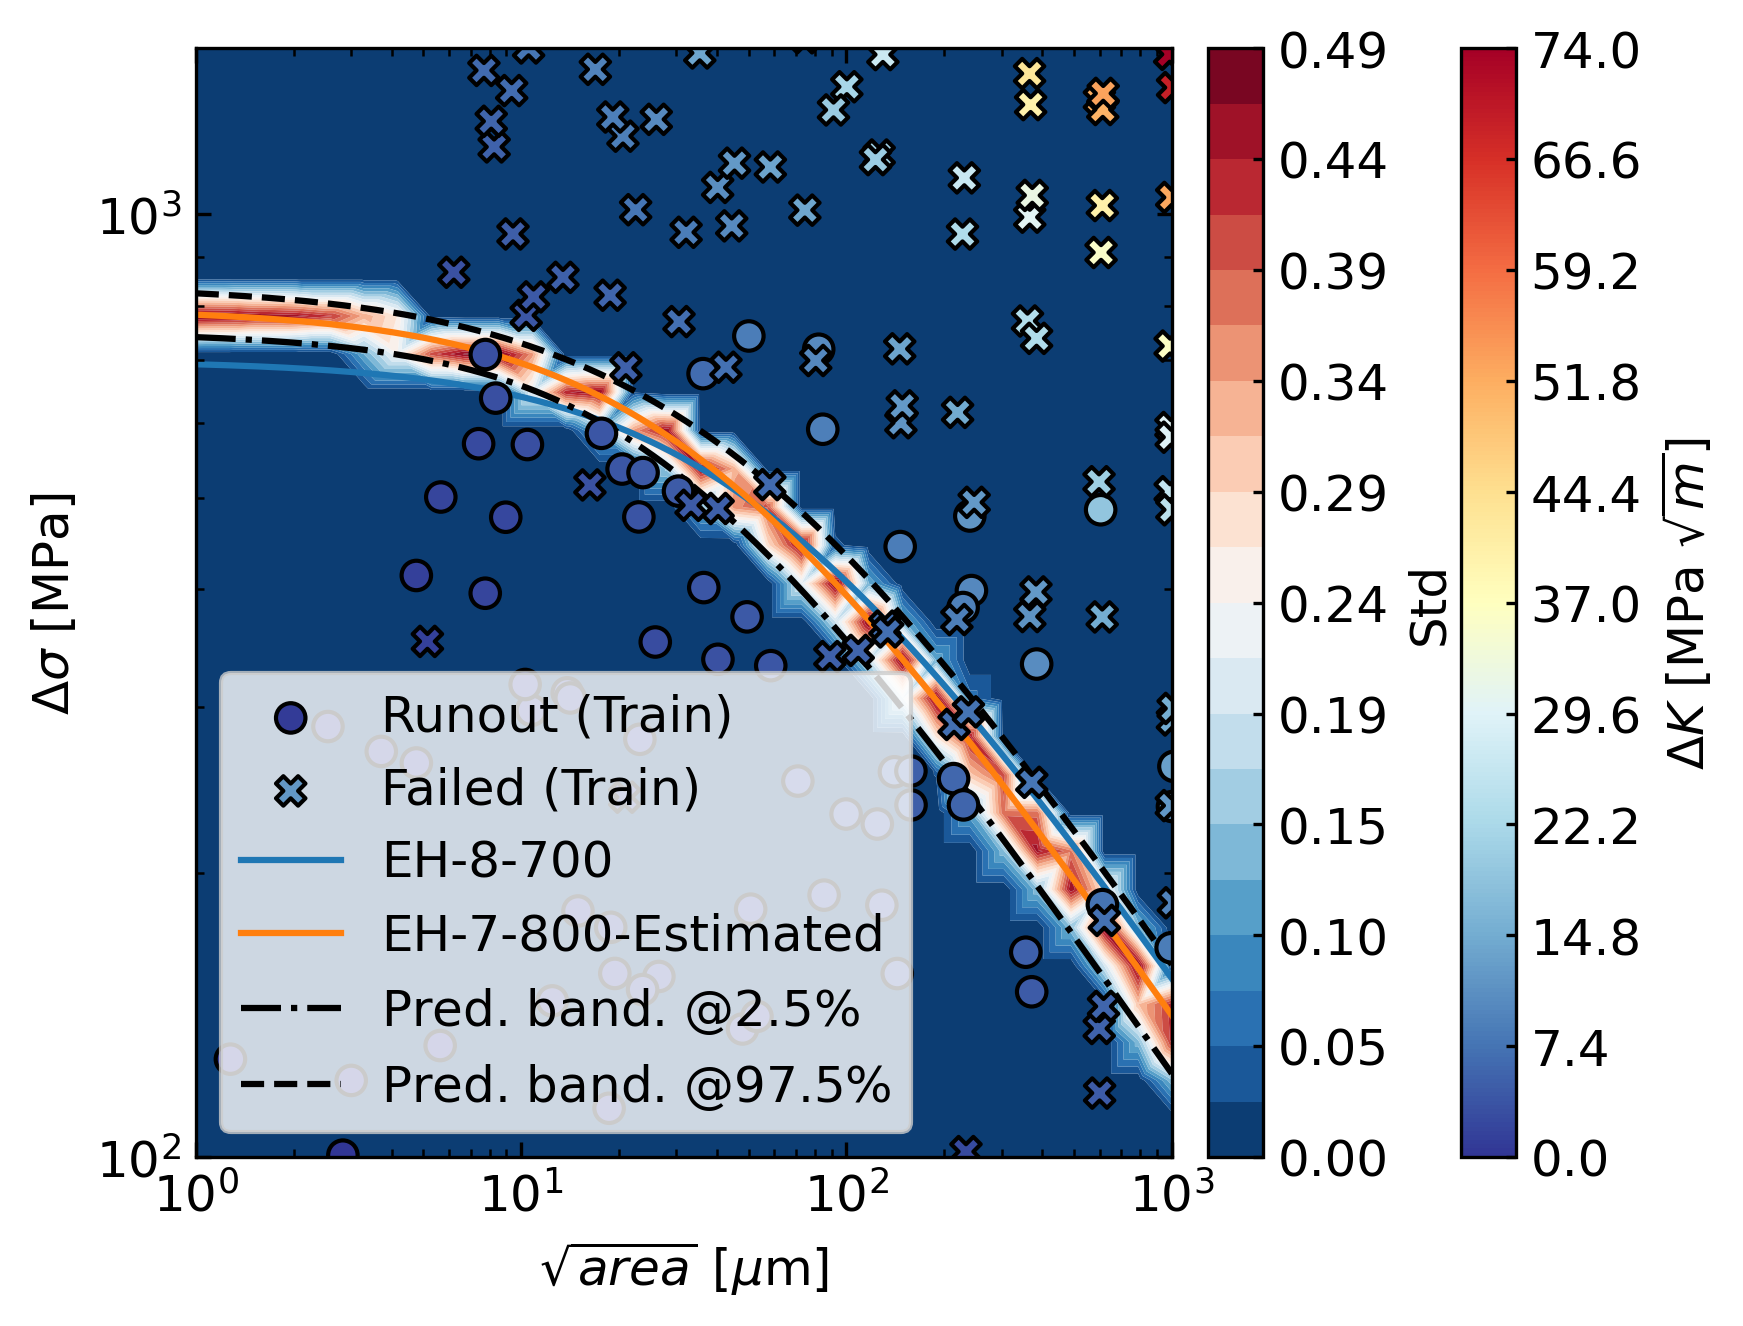

In [33]:
p = PreProViewer([1,1000], [100,1500], 1000, scale="log", name="EH-7-800")
p.config_canvas(xlabel="sq_a", ylabel="ds", cbarlabel="dk",
                translator=ElHaddadTranslator)
opt = ElHaddadCurve(dk_th=bay.theta_hat[0], ds_w=bay.theta_hat[1], Y=0.9,
                    name="EH-7-800-Estimated")
mc = MonteCarlo(ElHaddadCurve)
eval_grid = SyntheticDataset(name="EH-8-700_Eval")
eval_grid.make_grid([1,1000], [100,1500], 30, 30, spacing="log")

p.view(train_data=sd, curve=[eh, opt],
       prediction_interval=mc,
       mc_bayes=bay,
       mc_samples=10000,
       mc_distribution="joint",
       confidence=95,
       predictive_posterior=bay,
       post_samples=50,
       post_op=np.mean,
       post_data=eval_grid)

p.view(train_data=sd, curve=[eh, opt],
       prediction_interval=mc,
       mc_bayes=bay,
       mc_samples=10000,
       mc_distribution="joint",
       confidence=95,
       predictive_posterior=bay,
       post_samples=50,
       post_op=np.std,
       post_data=eval_grid)